In [5]:
!pip install 'shimmy>=0.2.1'
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.3 MB/s eta 0:00:00


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 314       |
|    ep_rew_mean     | -3.69e+03 |
| time/              |           |
|    fps             | 1030      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 82.9         |
|    ep_rew_mean          | -599         |
| time/                   |              |
|    fps                  | 785          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0117431935 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2         

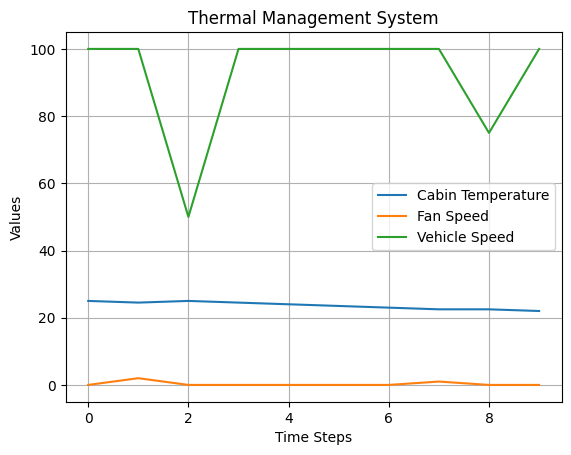

In [17]:
import gym
from stable_baselines3 import PPO
import time
import matplotlib.pyplot as plt
import numpy as np

class ThermalManagementEnv(gym.Env):
    def __init__(self, target_temp):
        super(ThermalManagementEnv, self).__init__()
        self.target_temp = target_temp
        self.current_temp = 25.0
        self.max_fan_speed = 10
        self.min_fan_speed = 0
        self.max_vehicle_speed = 100
        self.action_space = gym.spaces.Discrete(3)  # Fan off, Fan low, Fan high
        self.observation_space = gym.spaces.Box(
            low=0, high=100, shape=(2,), dtype=float
        )

    def step(self, action):
        fan_action = action
        if fan_action == 0:  # Fan off
            fan_speed = 0
        elif fan_action == 1:  # Fan low
            fan_speed = self.max_fan_speed // 2
        else:  # Fan high
            fan_speed = self.max_fan_speed

        self.current_temp += (fan_speed / 10) - 0.5
        reward = -abs(self.current_temp - self.target_temp)
        done = abs(self.current_temp - self.target_temp) < 0.5
        vehicle_speed = self.max_vehicle_speed - (fan_speed * 5)
        return [self.current_temp, vehicle_speed], reward, done, {}

    def reset(self):
        self.current_temp = 25.0
        return [self.current_temp, self.max_vehicle_speed]

# Train the model
target_temp = 22.0
env = ThermalManagementEnv(target_temp)

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
model.save("thermal_management_model")

# Load the trained model
loaded_model = PPO.load("thermal_management_model")

# Simulate and plot the results
# Simulate and collect results
obs = env.reset()
temps = [obs[0]]
fan_speeds = []
vehicle_speeds = [obs[1]]

while True:
    action, _ = loaded_model.predict([obs])
    obs, _, done, _ = env.step(action)
    temps.append(obs[0])
    fan_speeds.append(action)
    vehicle_speeds.append(obs[1])

    if done:
        fan_speeds.append(0)  # Append 0 for fan speed when done
        break

time_steps = np.arange(len(temps))


# Make sure fan_speeds has the same length as time_steps
fan_speeds = fan_speeds[:len(time_steps)]

plt.plot(time_steps, temps, label="Cabin Temperature")
plt.plot(time_steps, fan_speeds, label="Fan Speed")
plt.plot(time_steps, vehicle_speeds, label="Vehicle Speed")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.title("Thermal Management System")
plt.legend()
plt.grid(True)
plt.show()
